# Рисовалка кодом

In [13]:
%pip install numpy scipy pillow matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\devma\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from scipy import interpolate

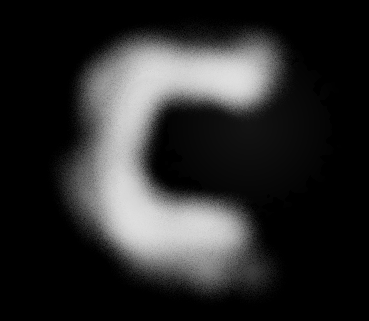

In [15]:
sample = Image.open("./2d_example.png")
sample

In [16]:
data = np.asarray(sample)
data.shape

(321, 369, 3)

In [17]:
data = data[:, :, 0]
data.shape

(321, 369)

## Один срез томографии

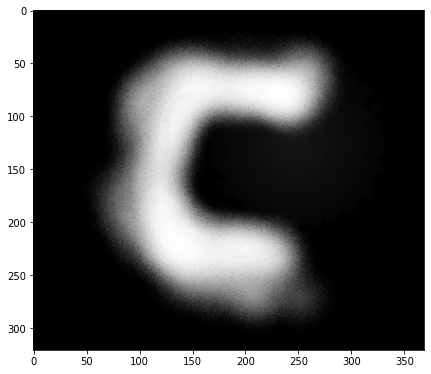

In [18]:
data = data / np.max(data)
fig, ax = plt.subplots(figsize=(7, 12))
plt.imshow(data, cmap=plt.get_cmap('gray'))

Линейная интерполяция изображения

In [19]:
x = np.linspace(0, 1, data.shape[1])
y = np.linspace(0, 1, data.shape[0])

f = interpolate.interp2d(x, y, data)

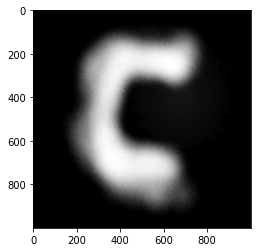

In [20]:
z = [[f(x, y) for x in np.linspace(0, 1, 1000)] for y in np.linspace(0, 1, 1000)]
plt.imshow(z, cmap=plt.get_cmap('gray'))

## Построение восьмеричного дерева

In [21]:
from dataclasses import dataclass
from typing import List, Union

MAX_DEPTH = 2
TOLERANCE = 1

@dataclass
class Leaf:
    center: np.array
    offset: float
    minimum: np.array
    maximum: np.array

Branch = "Branch"

@dataclass
class Branch:
    children: List[Union[List, Branch]]

def lerp(v1, v2, a):
    return v1 + (v2 - v1) * a

def gradient(f, x, y, dt=1e-9):
    c = f(x, y)
    return np.array([
        ((f(x + dt, y)) - c)/dt,
        ((f(x, y + dt)) - c)/dt
    ])[:, 0]

def generate_tree(f, minimum, maximum, depth):
    minimum = np.array(minimum)
    maximum = np.array(maximum)
    N = 4
    points = [
        lerp(minimum, maximum, (i / (N - 1), j / (N - 1)))
        for i in range(N)
        for j in range(N)
    ]
    values = [f(p[0], p[1]) for p in points]
    grads = [gradient(f, p[0], p[1]) for p in points]

    A = np.array([
        *[
            [g[0], g[1], -1]
            for g in grads
        ],
        [0.1, 0, 0],
        [0, 0.1, 0]
    ])

    medium = lerp(minimum, maximum, (0.5, 0.5))

    B = np.array([
        *[
            np.dot(g, p - medium) - v
            for g, p, v in zip(grads, points, values)
        ],
        [0],
        [0]
    ])

    x, *_ = np.linalg.lstsq(A, B, rcond=None)
    x = x[:, 0]

    center = medium + (x[0], x[1])
    
    if center[0] < minimum[0] or center[1] < minimum[1] or center[0] > maximum[0] or center[1] > maximum[1]:
        l = max(abs(x[0]), abs(x[1])) * 2
        center = medium + (maximum - minimum) * (x[0] / l, x[1] / l)
    
    offset = f(center[0], center[1])[0]
    
    

    error = 0
    for i in range(N * N):
        ti = values[i] + np.dot(grads[i], center - points[i])
        error_i = offset - ti
        error += error_i * error_i / (1 + np.dot(grads[i], grads[i]))

    if depth >= MAX_DEPTH or error < TOLERANCE:
        return Leaf(center=center, offset=offset, minimum=minimum, maximum=maximum)
    else:
        return Branch(children=[
            generate_tree(f, (minimum[0], minimum[1]),(medium[0], medium[1]),depth + 1),
            generate_tree(f, (medium[0], minimum[1]),(maximum[0], medium[1]),depth + 1),
            generate_tree(f, (minimum[0], medium[1]),(medium[0], maximum[1]),depth + 1),
            generate_tree(f, (medium[0], medium[1]),(maximum[0], maximum[1]),depth + 1),
        ])

In [22]:
MAX_DEPTH = 6
TOLERANCE = 0.05
tree = generate_tree(f, (0,0), (1,1), 0)

## Отображение дерева
Узел дерева делит пространство на 4 одинаковых прямоугольника.
Пространство разбивается на прямоугольники, в каждом из которых градиент изменяется в пределах заданной погрешности `TOLERANCE`. Точка - точка в которой градиент принимает среднее значение.

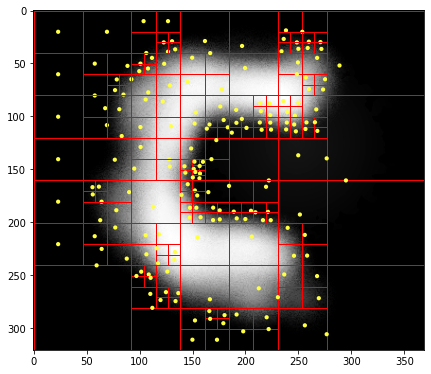

In [23]:
def draw_tree(tree):
    if type(tree) is Branch:
        for child in tree.children:
            draw_tree(child)
        return
    
    s = (data.shape[1], data.shape[0])
    
    w, h = (tree.maximum - tree.minimum) * s
    x, y = tree.minimum * s
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    x, y = tree.center * s
    circle = patches.Circle((x, y), 2, facecolor='#ff4')
    ax.add_patch(circle)

fig, ax = plt.subplots(figsize=(7, 12))
ax.imshow(data, cmap=plt.get_cmap('gray'))

draw_tree(tree)

## Рекурсивный обход всех соседей
Все соседи объединяются в четырех- и треугольные полигоны. 

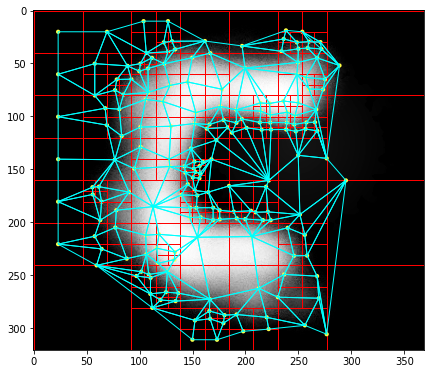

In [24]:
def enumerate_vertex(n1, n2, n3, n4):
    b1 = n1 if type(n1) is Branch else None
    b2 = n2 if type(n2) is Branch else None
    b3 = n3 if type(n3) is Branch else None
    b4 = n4 if type(n4) is Branch else None
    
    if b1 or b2 or b3 or b4:
        enumerate_vertex(
            b1.children[3] if b1 else n1,
            b2.children[2] if b2 else n2,
            b3.children[1] if b3 else n3,
            b4.children[0] if b4 else n4
        )
    else:
        s = (data.shape[1], data.shape[0])
        
        pol = patches.Polygon([
            n1.center * s,
            n2.center * s,
            n4.center * s,
            n3.center * s
        ], facecolor='none', edgecolor='aqua', linewidth=1)
        
        ax.add_patch(pol)

def enumerate_edge_y(n1, n2):
    b1 = n1 if type(n1) is Branch else None
    b2 = n2 if type(n2) is Branch else None
    
    if b1 or b2:
        enumerate_edge_y(
            b1.children[1] if b1 else n1,
            b2.children[0] if b2 else n2
        )
        enumerate_edge_y(
            b1.children[3] if b1 else n1,
            b2.children[2] if b2 else n2
        )
        
        enumerate_vertex(
            b1.children[1] if b1 else n1,
            b2.children[0] if b2 else n2,
            b1.children[3] if b1 else n1,
            b2.children[2] if b2 else n2
        )

def enumerate_edge_x(n1, n2):
    b1 = n1 if type(n1) is Branch else None
    b2 = n2 if type(n2) is Branch else None
    
    if b1 or b2:
        enumerate_edge_x(
            b1.children[2] if b1 else n1,
            b2.children[0] if b2 else n2
        )
        enumerate_edge_x(
            b1.children[3] if b1 else n1,
            b2.children[1] if b2 else n2
        )
        
        enumerate_vertex(
            b1.children[2] if b1 else n1,
            b1.children[3] if b1 else n1,
            b2.children[0] if b2 else n2,
            b2.children[1] if b2 else n2
        )
        
def enumerate_cell(tree):
    if type(tree) is Leaf:
        return
    
    for t in tree.children:
        enumerate_cell(t)
    
    enumerate_edge_x(tree.children[0], tree.children[2])
    enumerate_edge_x(tree.children[1], tree.children[3])
    enumerate_edge_y(tree.children[0], tree.children[1])
    enumerate_edge_y(tree.children[2], tree.children[3])
    enumerate_vertex(*tree.children)

fig, ax = plt.subplots(figsize=(7, 12))
ax.imshow(data, cmap=plt.get_cmap('gray'))

draw_tree(tree)
enumerate_cell(tree)

## Перечисление всех отрезков, аппроксимирующих изоповерхность
К каждому полигону применяют алгоритм Marching Squares, чтобы получить отрезки, аппроксимирующие изоповерхность.

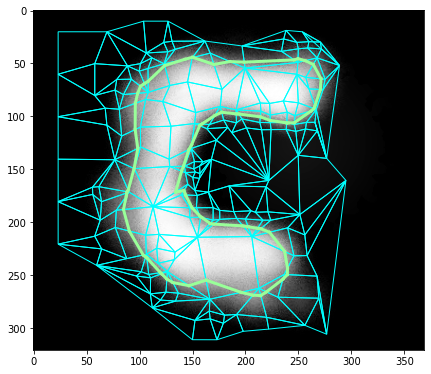

In [25]:
def adapt(v0, v1):
    """v0 and v1 are numbers of opposite sign. This returns how far you need to interpolate from v0 to v1 to get to 0."""

    return 0.5 if v1 == v0 else max(0, min((0 - v0) / (v1 - v0), 1))

def marching_cubes_2d_single_cell(n1, n2, n3, n4):
    """Returns a list of edges that approximate f's boundary for a single cell"""

    V = 0.5
    # Evaluate
    x0y0 = n1.offset - V
    x1y0 = n2.offset - V
    x0y1 = n3.offset - V
    x1y1 = n4.offset - V

    # There are 16 different cases that these points can be inside or outside.
    # We use binary counting to map the 4 truth values to a number between 0 and 15 inclusive.
    # It's even more in the 3d case!
    case = ((1 if x0y0 > 0 else 0) +
            (2 if x0y1 > 0 else 0) +
            (4 if x1y0 > 0 else 0) +
            (8 if x1y1 > 0 else 0))
    
    points = [
        lerp(n1.center, n2.center, adapt(x0y0, x1y0)) if x0y0 * x1y0 <= 0 else None,
        lerp(n1.center, n3.center, adapt(x0y0, x0y1)) if x0y0 * x0y1 <= 0 else None,
        lerp(n2.center, n4.center, adapt(x1y0, x1y1)) if x1y0 * x1y1 <= 0 else None,
        lerp(n3.center, n4.center, adapt(x0y1, x1y1)) if x0y1 * x1y1 <= 0 else None,
    ]

    # Several of the cases are inverses of each other where solid is non solid and visa versa
    # They have the same boundary, which cuts down the cases a bit.
    # But we swap the direction of the boundary, so that edges are always winding clockwise around the solid.
    # Getting those swaps correct isn't needed for our simple visualizations, but is important in other uses cases
    # particularly in 3d.

    if case == 0 or case == 15:
        # All outside / inside
        return []
    if case == 1 or case == 14:
        # Single corner
        return [points[0], points[1]]
    if case == 2 or case == 13:
        # Single corner
        return [points[1], points[3]]
    if case == 4 or case == 11:
        # Single corner
        return [points[2], points[0]]
    if case == 8 or case == 7:
        # Single corner
        return [points[3], points[2]]
    if case == 3 or case == 12:
        # Vertical split
        return [points[0], points[3]]
    if case == 5 or case == 10:
        # Horizontal split
        return [points[1], points[2]]
    if case == 9:
        # Two opposite corners, copy cases 1 and 8
        return [points[0], points[1], points[3], points[2]]
    if case == 6:
        # Two opposite corners, copy cases 2 and 4
        return [points[1], points[3], points[2], points[0]]

def enumerate_vertex(n1, n2, n3, n4):
    b1 = n1 if type(n1) is Branch else None
    b2 = n2 if type(n2) is Branch else None
    b3 = n3 if type(n3) is Branch else None
    b4 = n4 if type(n4) is Branch else None
    
    if b1 or b2 or b3 or b4:
        enumerate_vertex(
            b1.children[3] if b1 else n1,
            b2.children[2] if b2 else n2,
            b3.children[1] if b3 else n3,
            b4.children[0] if b4 else n4
        )
    else:
        s = (data.shape[1], data.shape[0])
        
        pol = patches.Polygon([
            n1.center * s,
            n2.center * s,
            n4.center * s,
            n3.center * s
        ], facecolor='none', edgecolor='aqua', linewidth=1)
        
        ax.add_patch(pol)

        lines = marching_cubes_2d_single_cell(n1, n2, n3, n4)
        
        for i in range(0, len(lines), 2):
            x1, y1 = lines[i] * s
            x2, y2 = lines[i + 1] * s
            
            ax.plot([x1, x2], [y1, y2], color="#9f9", linewidth=3, zorder=1000)

fig, ax = plt.subplots(figsize=(7, 12))
ax.imshow(data, cmap=plt.get_cmap('gray'))

enumerate_cell(tree)